In [5]:
import pandas as pd
from caveclient import CAVEclient
client = CAVEclient('minnie65_phase3_v1')
from datetime import datetime, timezone
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [64]:
###compare cg calls with Leila's classifier
settime = datetime(2023, 9, 19, 4, 0, 0, 0, tzinfo=timezone.utc)
md3 = client.materialize.query_table('aibs_metamodel_celltypes_v661', timestamp = settime)

df = client.materialize.query_table('cg_cell_type_calls', timestamp = settime)
print (df.shape)
##find which calls where annototator disagrees to drop
df['duplicated'] = df.duplicated(subset ='post_pt_root_id', keep = False)
df_dup = df.loc[df['duplicated'] == True]
df_dup_group = df_dup.groupby(by = ['post_pt_root_id', 'cell_type']).count().reset_index()

exclude_selfdisagree = df_dup_group.loc[df_dup_group['duplicated'] == 1].reset_index()
exclude_selfdisagree['exclude'] = 1
exclude_id = exclude_selfdisagree[['post_pt_root_id', 'exclude']]
print (exclude_id.shape)

df_toexclude = pd.merge(df, exclude_id, left_on = 'post_pt_root_id', right_on = 'post_pt_root_id', how = 'left')
print (df_toexclude.shape)
print (df_toexclude.head(40))

df2 = df_toexclude.loc[df_toexclude['exclude'] != 1]
print (df2.shape)
df3 = df2.drop_duplicates(subset ='post_pt_root_id')
print (df3.shape)
df_comp = pd.merge(df3, md3, left_on = 'post_pt_root_id', right_on = 'pt_root_id', how = 'inner')
print (df_comp.shape)
df_comp = df_comp.drop_duplicates(subset ='post_pt_root_id')
print (df_comp.shape)

# ##renaming cell types and removing non neuronal cells
# df_comp['cell_type_x'] = df_comp['cell_type_x'].str.replace('1P','23P')
# df_comp['cell_type_x'] = df_comp['cell_type_x'].str.replace('5P_IT','5P-IT')
# df_comp['cell_type_x'] = df_comp['cell_type_x'].str.replace('5P_NP','5P-NP')
# df_comp['cell_type_x'] = df_comp['cell_type_x'].str.replace('5P_PT','5P-ET')                   
                   
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('BC','INH')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('MC','INH')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('NGC','INH')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('BPC','INH')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('6P-CT','6P')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('6P-IT','6P')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('OPC','Glia')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('astrocyte','Glia')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('oligo','Glia')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('microglia','Glia')
# df_comp['cell_type_y'] = df_comp['cell_type_y'].str.replace('pericyte','Glia')
# df_comp_noglia = df_comp.loc[df_comp['cell_type_y'] != 'Glia']
# df_comp_npnoglia = df_comp_noglia.loc[df_comp['cell_type_y'] != '5P-NP']
# df_comp_npnoglia = df_comp_npnoglia.loc[df_comp['cell_type_x'] != '5P-NP']

# df_comp_sub = df_comp_npnoglia[['cell_type_x','pt_root_id',  'cell_type_y' ]]
# df_comp_sub = df_comp_sub.rename(columns={"cell_type_x": "Manual", "cell_type_y": "Predicted"})
# # df_pivot = pd.pivot_table(df_comp_sub, index=['Manual'],
# #                     columns=['Predicted'], aggfunc="count", fill_value=0)
# df_ct = pd.crosstab(df_comp_sub["Manual"], df_comp_sub["Predicted"])
# print (df_ct)
# df_ct_norm = pd.crosstab(df_comp_sub["Manual"], df_comp_sub["Predicted"], normalize = "index")
# print (df_ct_norm)
# df_ct_norm = df_ct_norm*100

(2868, 17)
(34, 2)
(2900, 19)
    id                   created valid  target_id classification_system  \
0    1 2022-02-07 19:04:03+00:00     t  252841327              cg_calls   
1    2 2022-02-07 19:04:03+00:00     t  252889242              cg_calls   
2    3 2022-02-07 19:04:03+00:00     t  234601405              cg_calls   
3    4 2022-02-07 19:04:03+00:00     t  248722118              cg_calls   
4    5 2022-02-07 19:04:03+00:00     t  220312874              cg_calls   
5    6 2022-02-07 19:04:03+00:00     t  183058872              cg_calls   
6    7 2022-02-07 19:04:03+00:00     t  244605791              cg_calls   
7    8 2022-02-07 19:04:03+00:00     t  254666730              cg_calls   
8    9 2022-02-07 19:04:03+00:00     t  220954051              cg_calls   
9   10 2022-02-07 19:04:03+00:00     t  280018388              cg_calls   
10  11 2022-02-07 19:04:03+00:00     t  223330668              cg_calls   
11  12 2022-02-07 19:04:03+00:00     t  244588196              cg_call

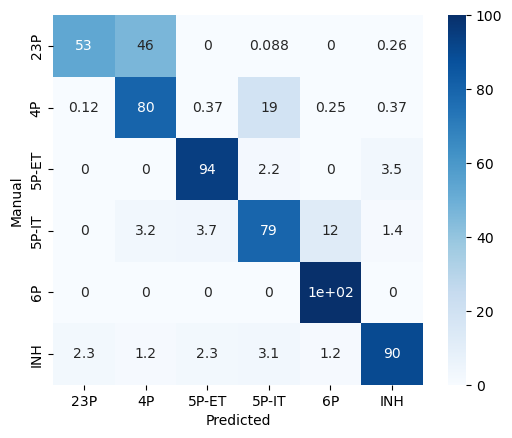

In [67]:
ax = sns.heatmap(df_ct_norm, cmap = "Blues", annot= True, square = True)
# plt.savefig('manual_vs_classifier_aibs_metamodel_celltypes_v661_qdate09192023_normx100_blues_090624.pdf')

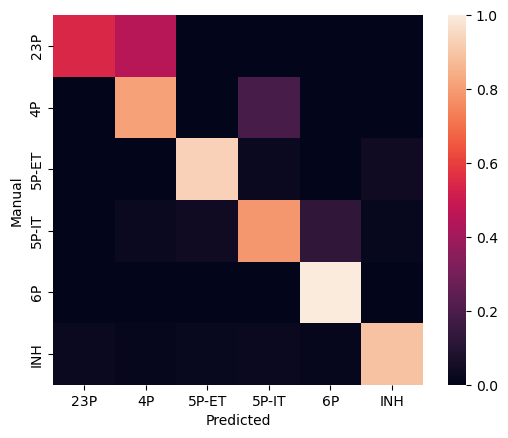

In [46]:
ax = sns.heatmap(df_ct_norm, square = True)
# plt.savefig('manual_vs_classifier_aibs_metamodel_celltypes_v661_qdate09192023_050424.png')